In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
output_path = '/home/ubuntu/Documents/result_small'

In [3]:
import os
os.chdir('/home/ubuntu/fastai/old')
# This file contains all the main external libs we'll use
from fastai.imports import *

In [4]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from pathlib import *
import pandas as pd
import numpy as np

In [5]:
#checking wheteher cuda and cudnn are available. Cuda is necessary & Cudnn is optional, it makes computation faster
torch.cuda.is_available()

True

In [6]:
torch.backends.cudnn.enabled

True

In [7]:
#using  device 1-gpu
torch.cuda.set_device(0)
torch.cuda.current_device()

0

In [8]:
#checking the data
input_path = '/home/ubuntu/Documents/'
# classes = pd.read_csv(input_path+'scene_classes.csv',header=None)
# classes.rename(columns={0:'label_id',2:'class',1:'to_drop'},inplace=True)
# classes.drop('to_drop',inplace=True,axis=1)

labels = pd.read_csv(input_path+'label.csv')
# labels.drop('Unnamed: 0',inplace=True,axis=1)

# labels['label_id'] = labels['label_id'].astype(str)
# classes['label_id']= classes['label_id'].astype(str)

# labels = labels.merge(classes,how='left')
# labels = labels[~labels['class'].isna()]
# labels.reset_index(drop=True,inplace=True)

labels_model = labels[['image_id','class']]

In [9]:
labels_model['class'].unique()

array(['real', 'fake'], dtype=object)

In [10]:
def get_data(f_model,sz,bs,val_idxs,aug_tfms,root_path,train_folder,trn_idxs,label_csv,test_folder,skip_header,augmentation_required):
    if (augmentation_required):
        tfms = tfms_from_model(f_model, sz,aug_tfms=aug_tfms,max_zoom=1.1)
    else:
        tfms =  tfms_from_model(f_model, sz)
    
    label_csv = label_csv.loc[np.concatenate((trn_indx,val_idxs)),:]#.drop((label_csv.index != val_idxs) | (label_csv.index != trn_idxs))
    
    label_csv.to_csv(str(root_path)+'temp_label_file.csv',index=False)
    
    return ImageClassifierData.from_csv_noise(root_path, train_folder,str(root_path)+'temp_label_file.csv',bs=bs,tfms=tfms,
                     val_idxs=val_idxs,test_name=test_folder,skip_header=skip_header)

In [11]:
def exp_name(output_path,freeze,model_name,lrn,sz):
    return output_path+freeze+'_'+'_'+model_name+'_lr'+str(lrn)+'_sz'+str(sz)

In [12]:
os.listdir("../../Documents/result_small/temp_model_store/")

['models', 'tmp', 'temp_label_file.csv']

In [13]:
label_csv = labels_model.copy()
#a root path of the data (used for storing trained models, precomputed values, etc)
root_path=r'/home/ubuntu/Documents/result_small/temp_model_store/'
#a name of the folder in which training images are contained.
train_folder = r'/home/ubuntu/Documents/train/'
#a name of the folder which contains test images.
test_folder= r'/home/ubuntu/share/stage-3/stage3_image_data/test/test/'

In [14]:
#for generating the validation indexes
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
labels_splits = labels.copy()
X= labels['class'].astype(str)
y=labels['class'].astype(str)

for train_index, test_index in sss.split(X, y):
    trn_indx = train_index
    val_idxs = test_index

In [59]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
labels_splits = labels.copy()
X = labels.loc[val_idxs, 'class'].astype(str)
y = labels.loc[val_idxs, 'class'].astype(str)

for train_index, test_index in sss.split(X, y):
    trn_indx = train_index
    val_idxs = test_index

In [15]:
f_model=resnet50
sz=256
aug_tfms=transforms_side_on
max_zoom=1.1
bs=32
#use this if we dont need augmentation
augmentation_required = True

model_name=str(f_model).split(' ')[1]

In [16]:
label_csv.loc[np.concatenate((trn_indx,val_idxs)),:].shape
# np.concatenate((trn_indx,val_idxs)).shape

(32260, 2)

In [17]:
#making data object
data = get_data(f_model,sz,bs,val_idxs,aug_tfms,root_path,train_folder,trn_indx,label_csv,test_folder,skip_header=True,augmentation_required=augmentation_required)

In [18]:
def weighted_f1(y_pred, y_true):
    y = [1 if i == "real" else 0 for i in y_true]
    f1R = fbeta(y_pred, torch.ByteTensor(np.array(y)).cuda(), thresh=0.5, beta=1)
    f1R *= np.sum(y)
    
    y = [0 if i == "real" else 1 for i in y_true]
    f1F = fbeta(1-y_pred, torch.ByteTensor(np.array(y)).cuda(), thresh=0.5, beta=1)
    f1F *= np.sum(y)
    
    return (f1F+f1R)/len(y)

In [19]:
trn_label_count_f = np.sum(labels.loc[trn_indx, "class"].apply(lambda x: 1 if x == "fake" else 0))
trn_label_count_r = np.sum(labels.loc[trn_indx, "class"].apply(lambda x: 1 if x == "real" else 0))
trn_weights = [trn_label_count_r, trn_label_count_f]/(trn_label_count_f+trn_label_count_r)

In [20]:
torch.cuda.set_device(0)
torch.cuda.current_device()
learn = ConvLearner.pretrained(f_model, data,precompute=False, metrics=[accuracy, f1])
learn.crit = nn.CrossEntropyLoss(weight=torch.FloatTensor(trn_weights).cuda())
# lrf=learn.lr_find()

# learn.sched.plot()


In [21]:
learn.freeze()

In [22]:
lrn=1e-3

In [23]:
lrn

0.001

In [117]:
learn.fit(lrn, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   f1             
    0      0.85883    0.737978   0.55       0.384952  
    1      0.787873   0.695449   0.615      0.419023       
    2      0.732969   0.693084   0.63       0.427289       
    3      0.719706   0.669567   0.605      0.419277       
    4      0.698608   0.677552   0.585      0.443546       
    5      0.685037   0.670043   0.595      0.41734        
    6      0.679545   0.6748     0.5875     0.411291       


[array([0.6748]), 0.5875, 0.41129117681051836]

In [37]:
preds, y = learn.TTA(8, is_test=False)
# learn.predict()
# preds, y = learn.predict_with_targs(is_test=False)

Exception ignored in: <generator object DataLoader.__iter__ at 0x7fda6ab11938>
Traceback (most recent call last):
  File "/home/ubuntu/fastai/old/fastai/dataloader.py", line 89, in __iter__
    yield get_tensor(batch, self.pin_memory, self.half)
  File "/home/ubuntu/.conda/envs/fastai_old/lib/python3.6/concurrent/futures/_base.py", line 611, in __exit__
    self.shutdown(wait=True)
  File "/home/ubuntu/.conda/envs/fastai_old/lib/python3.6/concurrent/futures/thread.py", line 152, in shutdown
    t.join()
  File "/home/ubuntu/.conda/envs/fastai_old/lib/python3.6/threading.py", line 1056, in join
    self._wait_for_tstate_lock()
  File "/home/ubuntu/.conda/envs/fastai_old/lib/python3.6/threading.py", line 1072, in _wait_for_tstate_lock
    elif lock.acquire(block, timeout):
KeyboardInterrupt: 


KeyboardInterrupt: 

In [46]:
# np.sum(preds[:,0,:],axis=0)
# learn.TTA()
# learn.data.val_ds.fnames


In [61]:
pr = []
pk = np.mean(np.exp(preds), 0)
for p in pk:
    pr.append(p[1] > 0.8)
# for p in range(preds.shape[1]):
#     pr.append(np.mean(np.exp(preds[:,p,:],axis=0)[1]) > 0.5)
pr = np.array(pr)

In [ ]:
# pr.shape

In [36]:
df = pd.DataFrame(pk, columns=["Real", "Fake"])
df["Filename"] = learn.data.val_ds.fnames
df.to_csv("val_noisepred.csv", index=False)

In [50]:
from sklearn.metrics import roc_curve, auc

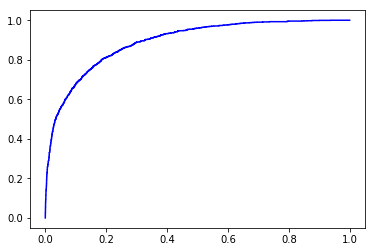

In [67]:
fpr , tpr , thresh = roc_curve(y , pk[:,1])
roc_auc = auc(fpr , tpr)

plt.plot(fpr , tpr , 'b' , label = 'AUC = %0.2f' %roc_auc)
plt.show()

In [73]:
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

In [75]:
threshold = Find_Optimal_Cutoff(y, pk[:,1])
print(threshold)

[0.36900386214256287]


/home/ubuntu/.conda/envs/fastai_old/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [80]:
threshold

[0.36900386214256287]

In [103]:
from sklearn.metrics import f1_score
f1_score(pk[:,1] > 1-threshold[0], y, average="weighted")

0.8496808309532603

In [102]:
from sklearn.metrics import accuracy_score
accuracy_score(pk[:,1] > 1-threshold[0], y)

0.8456292622442654

In [84]:
# data.val_ds.fnames
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresh[optimal_idx]
optimal_threshold

0.37124702

In [73]:
from sklearn.metrics import f1_score
f1_score(pr.astype(int), y)

0.6444363899963755

(array([2092.,  566.,  408.,  315.,  270.,  240.,  213.,  175.,  196.,  171.,  155.,  155.,  141.,  133.,
         122.,  147.,  150.,  167.,  208.,  428.]),
 array([0.     , 0.05   , 0.1    , 0.14999, 0.19999, 0.24999, 0.29999, 0.34998, 0.39998, 0.44998, 0.49998,
        0.54997, 0.59997, 0.64997, 0.69997, 0.74996, 0.79996, 0.84996, 0.89996, 0.94995, 0.99995],
       dtype=float32),
 <a list of 20 Patch objects>)

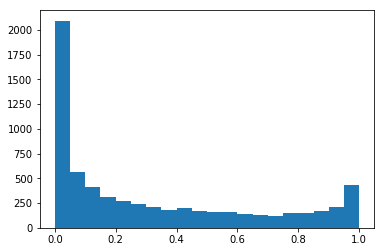

In [44]:
plt.hist(pk[:,1],20)

[[4582  210]
 [ 771  889]]


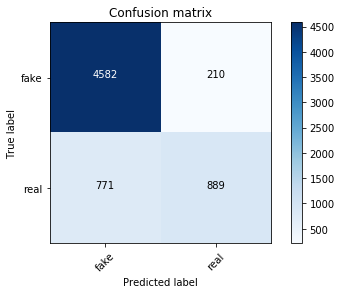

In [76]:
# interp = ClassificationInterpretation.from_learner(learn)
# interp.plot_confusion_matrix() 
# interp.plot_top_losses(21, figsize=(15,11)) 
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, pr.astype(int))
plot_confusion_matrix(cm, data.classes)

In [77]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

/home/ubuntu/.conda/envs/fastai_old/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Most incorrect fake


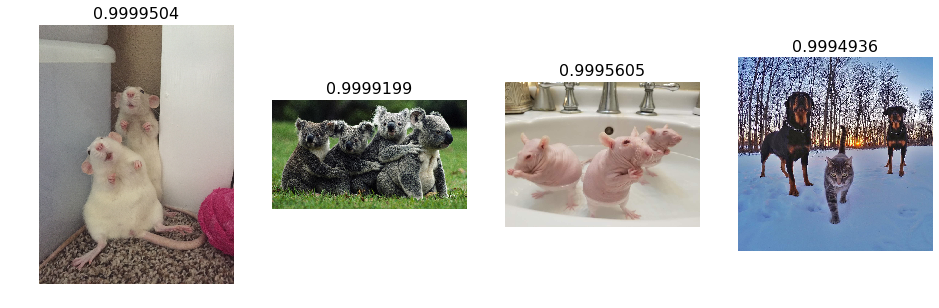

In [94]:
probs = pk[:,1]
PATH = ""
plot_val_with_title(most_by_correct(0, False), "Most incorrect fake")

/home/ubuntu/.conda/envs/fastai_old/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Most incorrect real


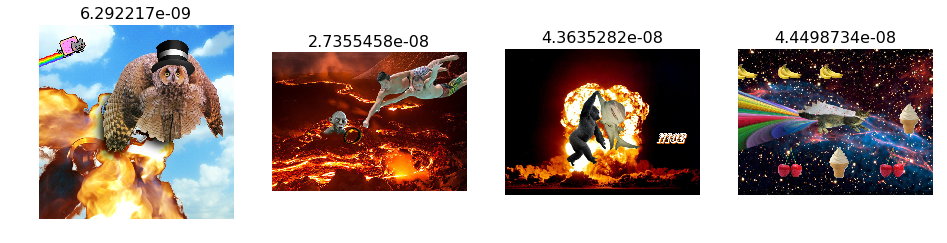

In [93]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect real")

In [131]:
learn.save(exp_name(output_path,'frz',model_name,lrn,sz))

In [24]:
#loading the previous saved model and unfreezing the network for more training
# learn.load(exp_name(output_path,'frz',model_name,lrn,sz))
learn.load("../../../result_smallfrz__resnet50_lr0.001_sz256")
# learn.unfreeze()
# learn.bn_freeze(True)

lr=np.array([lrn/100,lrn/10,lrn])

# learn.fit(lr, 3, cycle_len=1,cycle_mult=2)
# learn.save(exp_name(output_path,'unfrz',model_name,lrn,sz))


In [25]:
learn.load("../../../result_smallunfrz__resnet50_lr0.001_sz256")

In [26]:
sz=512

learn.set_data(get_data(f_model,sz,8,val_idxs,aug_tfms,root_path,train_folder,trn_indx,label_csv,test_folder,skip_header=True,augmentation_required=augmentation_required))
learn.freeze()
# learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
learn.load("../../../result_smallfrz__resnet50_lr0.001_sz512")

In [46]:
# learn.save(exp_name(output_path,'frz',model_name,lrn,sz))

In [47]:
learn.unfreeze()
# learn.bn_freeze(True)
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

    1      0.489406   0.478714   0.800992   0.546307             
    2      0.460225   0.460406   0.780378   0.566492             


[array([0.46041]), 0.7803781773093614, 0.5664922051642809]

In [52]:
# learn.save(exp_name(output_path,'unfrz',model_name,lrn,sz))

In [27]:
learn.unfreeze()
learn.load(exp_name(output_path,'unfrz',model_name,lrn,sz))

In [28]:
exp_name(output_path,'unfrz',model_name,lrn,sz)

'/home/ubuntu/Documents/result_smallunfrz__resnet50_lr0.001_sz512'

In [60]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   f1                   
    0      0.336628   0.449193   0.801767   0.587412  
    1      0.395417   0.484466   0.729851   0.561902             
    2      0.262419   0.456904   0.816646   0.585147             


[array([0.4569]), 0.8166460012399256, 0.5851474767970165]

In [84]:
learn.save(exp_name(output_path,'unfrz',model_name,lrn,sz))

In [ ]:
sz=1024

learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(exp_name(output_path,'unfrz',model_name,lrn,sz))

In [ ]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

In [ ]:
f1(preds,y)

In [102]:
list(learn.children)[:-6]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
 ReLU(inplace),
 MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False),
 Sequential(
   (0): Bottleneck(
     (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
     (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
     (relu): ReLU(inplace)
     (downsample): Sequential(
       (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
     )
   )
   (1): Bottleneck(
     (conv1): Conv2d(256, 64, kernel_size=(

In [103]:
modelA = nn.Sequential(*list(learn.children)[:-7])

In [105]:
for param in modelA.parameters():
    param.requires_grad = False

In [ ]:
inputs, labels = next(iter(dataloders['train']))
inputs, labels = Variable(inputs), Variable(labels)
outputs = res50_conv(inputs)

In [120]:
outputs= []
def hook(module, input, output):
    outputs.append(output)

In [114]:
learn.model[10]

BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True)

In [121]:
output = [] 
learn.model[10].register_forward_hook(hook)
out = learn.model(Variable(torch.randn(1, 3, 512, 512)).cuda())
# out = learn.model(res1)
print(outputs)

[Variable containing:
-0.3908 -0.9363 -1.1806  ...  -0.0458 -0.8557 -0.0181
[torch.cuda.FloatTensor of size 1x4096 (GPU 0)]
, Variable containing:
-0.3908 -0.9363 -1.1806  ...  -0.0458 -0.8557 -0.0181
[torch.cuda.FloatTensor of size 1x4096 (GPU 0)]
, Variable containing:
-0.3908 -0.9363 -1.1806  ...  -0.0458 -0.8557 -0.0181
[torch.cuda.FloatTensor of size 1x4096 (GPU 0)]
, Variable containing:
-0.3908 -0.9363 -1.1806  ...  -0.0458 -0.8557 -0.0181
[torch.cuda.FloatTensor of size 1x4096 (GPU 0)]
, Variable containing:
-0.3908 -0.9363 -1.1806  ...  -0.0458 -0.8557 -0.0181
[torch.cuda.FloatTensor of size 1x4096 (GPU 0)]
, Variable containing:
-0.3908 -0.9363 -1.1806  ...  -0.0458 -0.8557 -0.0181
[torch.cuda.FloatTensor of size 1x4096 (GPU 0)]
]


In [122]:
torch.cuda.empty_cache()